# House Price Prediction using ANN

### Libraries used 
- PyTorch 


In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
df=pd.read_csv('houseprice.csv',usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
                                         "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()

In [3]:
df.shape

(1201, 10)

In [4]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice
0,60,RL,65.0,8450,Pave,Reg,2003,856,854,208500
1,20,RL,80.0,9600,Pave,Reg,1976,1262,0,181500
2,60,RL,68.0,11250,Pave,IR1,2001,920,866,223500
3,70,RL,60.0,9550,Pave,IR1,1915,961,756,140000
4,60,RL,84.0,14260,Pave,IR1,2000,1145,1053,250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1201 non-null   int64  
 1   MSZoning     1201 non-null   object 
 2   LotFrontage  1201 non-null   float64
 3   LotArea      1201 non-null   int64  
 4   Street       1201 non-null   object 
 5   LotShape     1201 non-null   object 
 6   YearBuilt    1201 non-null   int64  
 7   1stFlrSF     1201 non-null   int64  
 8   2ndFlrSF     1201 non-null   int64  
 9   SalePrice    1201 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 103.2+ KB


In [6]:
for i in df.columns:
    print("Column name {} and unique values are {}".format(i,len(df[i].unique())))

Column name MSSubClass and unique values are 15
Column name MSZoning and unique values are 5
Column name LotFrontage and unique values are 110
Column name LotArea and unique values are 869
Column name Street and unique values are 2
Column name LotShape and unique values are 4
Column name YearBuilt and unique values are 112
Column name 1stFlrSF and unique values are 678
Column name 2ndFlrSF and unique values are 368
Column name SalePrice and unique values are 597


**Note**
- Consider features with less values as categorical features
- And features with more values as continuous features

## Feature engineering YearBuilt

In [7]:
import datetime
datetime.datetime.now().year

2020

In [8]:
df['Total Years'] = datetime.datetime.now().year - df['YearBuilt']

In [9]:
df.drop("YearBuilt", axis=1, inplace=True)

In [10]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,60,RL,65.0,8450,Pave,Reg,856,854,208500,17
1,20,RL,80.0,9600,Pave,Reg,1262,0,181500,44
2,60,RL,68.0,11250,Pave,IR1,920,866,223500,19
3,70,RL,60.0,9550,Pave,IR1,961,756,140000,105
4,60,RL,84.0,14260,Pave,IR1,1145,1053,250000,20


## Working with categorical and continuous features

### For categorical feature

1. We will perform LabelEncoder
2. We will take all categorical features and convert it into numpy and torch (tensors)
3. We use Embedding Layers (similar as Word2vec)

https://www.fast.ai/2018/04/29/categorical-embeddings/

https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/

#### Step 1

In [11]:
cat_features = ["MSSubClass", "MSZoning", "Street", "LotShape"]

out_features = "SalePrice"

In [12]:
df["MSSubClass"].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  80, 160,  75, 180,
        40,  85])

In [13]:
from sklearn.preprocessing import LabelEncoder

lbl_encoders = {}
lbl_encoders["MSSubClass"] = LabelEncoder()
lbl_encoders["MSSubClass"].fit_transform(df["MSSubClass"])

array([5, 0, 5, ..., 6, 0, 0])

In [14]:
lbl_encoders={}
for feature in cat_features:
    lbl_encoders[feature]=LabelEncoder()
    df[feature]=lbl_encoders[feature].fit_transform(df[feature])

In [15]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,5,3,65.0,8450,1,3,856,854,208500,17
1,0,3,80.0,9600,1,3,1262,0,181500,44
2,5,3,68.0,11250,1,0,920,866,223500,19
3,6,3,60.0,9550,1,0,961,756,140000,105
4,5,3,84.0,14260,1,0,1145,1053,250000,20
...,...,...,...,...,...,...,...,...,...,...
1455,5,3,62.0,7917,1,3,953,694,175000,21
1456,0,3,85.0,13175,1,3,2073,0,210000,42
1457,6,3,66.0,9042,1,3,1188,1152,266500,79
1458,0,3,68.0,9717,1,3,1078,0,142125,70


**Note**
- We are giving indexes to categories in columns 
- We will use these indexes for embedding in future

#### Step 2

In [16]:
### Stacking and Converting into Numpy Array

cat_features=np.stack([df['MSSubClass'],df['MSZoning'],df['Street'],df['LotShape']],1)
cat_features

array([[5, 3, 1, 3],
       [0, 3, 1, 3],
       [5, 3, 1, 0],
       ...,
       [6, 3, 1, 3],
       [0, 3, 1, 3],
       [0, 3, 1, 3]])

In [17]:
### Convert Numpy to Tensors 

import torch

cat_features = torch.tensor(cat_features, dtype=torch.int64)
cat_features

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

In [18]:
## CONTINUOUS FEATURE

cont_features=[]
for i in df.columns:
    if i in ["MSSubClass", "MSZoning", "Street", "LotShape","SalePrice"]:
        pass
    else:
        cont_features.append(i)

In [19]:
cont_features

['LotFrontage', 'LotArea', '1stFlrSF', '2ndFlrSF', 'Total Years']

In [20]:
### Stacking continuous variable to a tensor

cont_values=np.stack([df[i].values for i in cont_features],axis=1)
cont_values=torch.tensor(cont_values,dtype=torch.float)
cont_values

tensor([[   65.,  8450.,   856.,   854.,    17.],
        [   80.,  9600.,  1262.,     0.,    44.],
        [   68., 11250.,   920.,   866.,    19.],
        ...,
        [   66.,  9042.,  1188.,  1152.,    79.],
        [   68.,  9717.,  1078.,     0.,    70.],
        [   75.,  9937.,  1256.,     0.,    55.]])

In [21]:
cont_values.dtype

torch.float32

In [22]:
### Dependent Feature 

y=torch.tensor(df['SalePrice'].values,dtype=torch.float).reshape(-1,1)
y

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1201 non-null   int64  
 1   MSZoning     1201 non-null   int64  
 2   LotFrontage  1201 non-null   float64
 3   LotArea      1201 non-null   int64  
 4   Street       1201 non-null   int64  
 5   LotShape     1201 non-null   int64  
 6   1stFlrSF     1201 non-null   int64  
 7   2ndFlrSF     1201 non-null   int64  
 8   SalePrice    1201 non-null   int64  
 9   Total Years  1201 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 103.2 KB


In [24]:
cat_features.shape,cont_values.shape,y.shape

(torch.Size([1201, 4]), torch.Size([1201, 5]), torch.Size([1201, 1]))

- 4 features are categorical 
- 5 features are continuous
- 1 feature is Dependent feature

#### Step 3: Embedding for Categorical Feature

In [25]:
len(df['MSSubClass'].unique())

15

In [26]:
### Dimensions for Cat features

cat_dims = [len(df[col].unique()) for col in ["MSSubClass", "MSZoning", "Street", "LotShape"]]

In [27]:
cat_dims

[15, 5, 2, 4]

**Note**
- Output dimensions should be set based on input dimensions but should be 50 or below 50

#####  min(50, features dimension/2)

##### If feature is 2 then -> min(50, 1) -> output dimension = 1

In [28]:
embedding_dim = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [29]:
embedding_dim

[(15, 8), (5, 3), (2, 1), (4, 2)]

In [30]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [31]:
embed_representation = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
embed_representation

ModuleList(
  (0): Embedding(15, 8)
  (1): Embedding(5, 3)
  (2): Embedding(2, 1)
  (3): Embedding(4, 2)
)

In [32]:
cat_features

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

In [33]:
## Top 4 cat features

cat_featuresz=cat_features[:4]
cat_featuresz

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        [6, 3, 1, 0]])

In [34]:
pd.set_option('display.max_rows', 500)

embedding_val=[]
for i,e in enumerate(embed_representation):
    embedding_val.append(e(cat_features[:,i]))

In [35]:
embedding_val

[tensor([[-1.0815, -1.2599,  0.8922,  ..., -0.5437, -0.5000, -0.9078],
         [ 0.3210,  0.7085, -0.4275,  ...,  0.5707, -1.1965, -0.0748],
         [-1.0815, -1.2599,  0.8922,  ..., -0.5437, -0.5000, -0.9078],
         ...,
         [ 0.5188, -1.0131, -0.2748,  ..., -0.1526,  1.4504,  0.4814],
         [ 0.3210,  0.7085, -0.4275,  ...,  0.5707, -1.1965, -0.0748],
         [ 0.3210,  0.7085, -0.4275,  ...,  0.5707, -1.1965, -0.0748]],
        grad_fn=<EmbeddingBackward>),
 tensor([[-0.6178, -1.0451,  0.8925],
         [-0.6178, -1.0451,  0.8925],
         [-0.6178, -1.0451,  0.8925],
         ...,
         [-0.6178, -1.0451,  0.8925],
         [-0.6178, -1.0451,  0.8925],
         [-0.6178, -1.0451,  0.8925]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.7361],
         [-0.7361],
         [-0.7361],
         ...,
         [-0.7361],
         [-0.7361],
         [-0.7361]], grad_fn=<EmbeddingBackward>),
 tensor([[ 1.0714,  2.0916],
         [ 1.0714,  2.0916],
         [ 0.5186, -0.308

**Note** 

- 1st feature (0-15 cat value) -> 8 dimensions
- 2nd feature (0-5)-> 3 dimensions
- 3rd feature (0-2)-> 1 dimension
- 4th feature (0-3)-> 2 dimensions 

In [36]:
## stack and concat everything properly 

z = torch.cat(embedding_val, 1) # concat
z

tensor([[-1.0815, -1.2599,  0.8922,  ..., -0.7361,  1.0714,  2.0916],
        [ 0.3210,  0.7085, -0.4275,  ..., -0.7361,  1.0714,  2.0916],
        [-1.0815, -1.2599,  0.8922,  ..., -0.7361,  0.5186, -0.3080],
        ...,
        [ 0.5188, -1.0131, -0.2748,  ..., -0.7361,  1.0714,  2.0916],
        [ 0.3210,  0.7085, -0.4275,  ..., -0.7361,  1.0714,  2.0916],
        [ 0.3210,  0.7085, -0.4275,  ..., -0.7361,  1.0714,  2.0916]],
       grad_fn=<CatBackward>)

In [37]:
#### Implement dropupout for preventing overfitting
dropout=nn.Dropout(.4)

In [38]:
final_embed = dropout(z)
final_embed

tensor([[-1.8025, -2.0999,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.5349,  1.1808, -0.7125,  ..., -0.0000,  1.7856,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.8643, -0.5134],
        ...,
        [ 0.0000, -1.6886, -0.4579,  ..., -1.2268,  1.7856,  0.0000],
        [ 0.0000,  1.1808, -0.7125,  ..., -0.0000,  0.0000,  3.4860],
        [ 0.5349,  0.0000, -0.7125,  ..., -1.2268,  1.7856,  0.0000]],
       grad_fn=<MulBackward0>)

## Putting it all together

In [39]:
##### Create a Feed Forward Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
class FeedForwardNN(nn.Module):

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [40]:
len(cont_features)

5

In [41]:
torch.manual_seed(100)
model=FeedForwardNN(embedding_dim,len(cont_features),1,[100,50],p=0.4)

In [42]:
model

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

### Define loss and optimizer

In [43]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [44]:
df.shape

(1201, 10)

In [45]:
cont_values

tensor([[   65.,  8450.,   856.,   854.,    17.],
        [   80.,  9600.,  1262.,     0.,    44.],
        [   68., 11250.,   920.,   866.,    19.],
        ...,
        [   66.,  9042.,  1188.,  1152.,    79.],
        [   68.,  9717.,  1078.,     0.,    70.],
        [   75.,  9937.,  1256.,     0.,    55.]])

In [46]:
cont_values.shape

torch.Size([1201, 5])

In [47]:
batch_size=1200
test_size=int(batch_size*0.15)
train_categorical=cat_features[:batch_size-test_size]
test_categorical=cat_features[batch_size-test_size:batch_size]
train_cont=cont_values[:batch_size-test_size]
test_cont=cont_values[batch_size-test_size:batch_size]
y_train=y[:batch_size-test_size]
y_test=y[batch_size-test_size:batch_size]

In [48]:
len(train_categorical),len(test_categorical),len(train_cont),len(test_cont),len(y_train),len(y_test)

(1020, 180, 1020, 180, 1020, 180)

In [49]:
epochs=5000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model(train_categorical,train_cont)
    loss=torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 200496.78125
Epoch number: 11 and the loss : 200493.4375
Epoch number: 21 and the loss : 200489.15625
Epoch number: 31 and the loss : 200482.609375
Epoch number: 41 and the loss : 200473.265625
Epoch number: 51 and the loss : 200461.359375
Epoch number: 61 and the loss : 200446.390625
Epoch number: 71 and the loss : 200429.359375
Epoch number: 81 and the loss : 200408.0
Epoch number: 91 and the loss : 200383.421875
Epoch number: 101 and the loss : 200355.3125
Epoch number: 111 and the loss : 200322.125
Epoch number: 121 and the loss : 200291.40625
Epoch number: 131 and the loss : 200252.0
Epoch number: 141 and the loss : 200206.625
Epoch number: 151 and the loss : 200162.234375
Epoch number: 161 and the loss : 200112.265625
Epoch number: 171 and the loss : 200059.765625
Epoch number: 181 and the loss : 200005.78125
Epoch number: 191 and the loss : 199946.25
Epoch number: 201 and the loss : 199881.46875
Epoch number: 211 and the loss : 199815.71875
Epoch n

Epoch number: 1771 and the loss : 154291.078125
Epoch number: 1781 and the loss : 154450.875
Epoch number: 1791 and the loss : 153776.3125
Epoch number: 1801 and the loss : 153205.859375
Epoch number: 1811 and the loss : 152825.9375
Epoch number: 1821 and the loss : 152306.703125
Epoch number: 1831 and the loss : 152465.375
Epoch number: 1841 and the loss : 151632.4375
Epoch number: 1851 and the loss : 150686.015625
Epoch number: 1861 and the loss : 150703.265625
Epoch number: 1871 and the loss : 150022.25
Epoch number: 1881 and the loss : 149367.515625
Epoch number: 1891 and the loss : 148458.890625
Epoch number: 1901 and the loss : 148624.265625
Epoch number: 1911 and the loss : 149128.0625
Epoch number: 1921 and the loss : 147791.40625
Epoch number: 1931 and the loss : 147403.875
Epoch number: 1941 and the loss : 146632.203125
Epoch number: 1951 and the loss : 146538.1875
Epoch number: 1961 and the loss : 146021.828125
Epoch number: 1971 and the loss : 145568.03125
Epoch number: 198

Epoch number: 3511 and the loss : 69188.2890625
Epoch number: 3521 and the loss : 68962.8671875
Epoch number: 3531 and the loss : 68625.609375
Epoch number: 3541 and the loss : 68312.4765625
Epoch number: 3551 and the loss : 67937.796875
Epoch number: 3561 and the loss : 66872.1484375
Epoch number: 3571 and the loss : 66265.7109375
Epoch number: 3581 and the loss : 65973.625
Epoch number: 3591 and the loss : 66088.0234375
Epoch number: 3601 and the loss : 64618.46484375
Epoch number: 3611 and the loss : 66831.9921875
Epoch number: 3621 and the loss : 65647.6796875
Epoch number: 3631 and the loss : 63235.4375
Epoch number: 3641 and the loss : 64999.8046875
Epoch number: 3651 and the loss : 62645.5625
Epoch number: 3661 and the loss : 63686.375
Epoch number: 3671 and the loss : 61990.53125
Epoch number: 3681 and the loss : 61463.703125
Epoch number: 3691 and the loss : 62889.4921875
Epoch number: 3701 and the loss : 60147.46484375
Epoch number: 3711 and the loss : 61698.23828125
Epoch nu

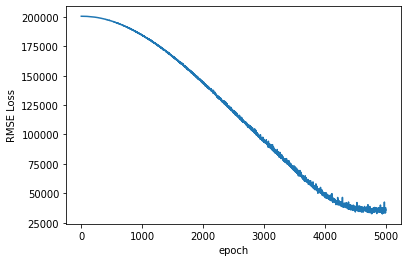

In [50]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [51]:
#### Validate the Test Data
y_pred=""
with torch.no_grad():
    y_pred=model(test_categorical,test_cont)
    loss=torch.sqrt(loss_function(y_pred,y_test))
print('RMSE: {}'.format(loss))

RMSE: 53878.58203125


In [52]:
data_verify=pd.DataFrame(y_test.tolist(),columns=["Test"])

In [53]:
data_predicted=pd.DataFrame(y_pred.tolist(),columns=["Prediction"])

In [54]:
data_predicted

,Prediction
0,117031.140625
1,213806.796875
2,138678.484375
3,223142.390625
4,213969.453125
5,203390.453125
6,152262.593750
7,295081.812500
8,158318.593750
9,357567.187500


In [55]:
final_output=pd.concat([data_verify,data_predicted],axis=1)
final_output['Difference']=final_output['Test']-final_output['Prediction']
final_output.head()

,Test,Prediction,Difference
0,130000.0,117031.140625,12968.859375
1,138887.0,213806.796875,-74919.796875
2,175500.0,138678.484375,36821.515625
3,195000.0,223142.390625,-28142.390625
4,142500.0,213969.453125,-71469.453125


In [56]:
#### Save the model
torch.save(model,'HousePrice.pt')

/Users/vishwasmore/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type FeedForwardNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [57]:
torch.save(model.state_dict(),'HouseWeights.pt')

In [58]:
### Loading the saved Model
embs_size=[(15, 8), (5, 3), (2, 1), (4, 2)]
model1=FeedForwardNN(embs_size,5,1,[100,50],p=0.4)

In [59]:
model1.load_state_dict(torch.load('HouseWeights.pt'))

<All keys matched successfully>

In [60]:
model1.eval()

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)